In [2]:
import numpy as np
from cellpose import plot, utils, io
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
from skimage.segmentation import clear_border
from numpy.polynomial.polynomial import polyfit
import glob

In [12]:
# These pixel conversion factors are valid only for GFP-probe images.
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX
# nM per unit intensity after background subtraction was calculated using Ap4 and Ap5 concentrations measued by FCS.
background = 180
# Both gave similar conversion factors. Ap4 factor is used. 
bright_to_conc = 0.058
# All Sc strains are het for GFP-probes so concentrations were multiplied by 2 before plotting.
# Cdc42 and Rac1 probes all use mCherry. Current plots are preliminary and proper conversion factors have not been generated. 
# Images and cellpose masks are loaded, background is subtracted, median pixel value within cell is used for concentration of probe.
# Volume is estimated as short_axis^2 * long_axis. Concentrations in cells are binned by volume and plotted as violins. 

In [13]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
background = 180 # Took measurements from many images in fiji and averaged.
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap4*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds) - background

remove_dead_and_background = np.multiply(meds < np.mean(meds)+2*np.std(meds), meds > np.mean(meds)-2*np.std(meds))
meds = meds[remove_dead_and_background]

vols = np.concatenate(vols)
vols = vols[remove_dead_and_background]
yeast_only = np.multiply(50 < vols, vols < 100)
print(f"nM per unit intesntiy = {53.359/np.mean(meds[yeast_only])}")
meds = meds * (53.359/np.median(meds[yeast_only])) # conversion factor based on FCS conc meas Ap4 

nM per unit intesntiy = 0.0581253906077779


In [14]:
bright_to_conc

0.058

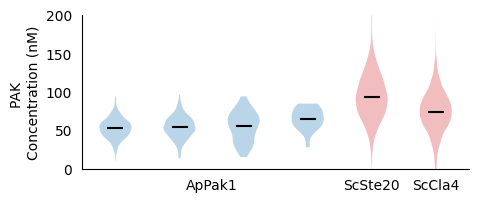

In [19]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap4*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds) 

meds = meds - background

remove_dead_and_background = np.multiply(meds < np.mean(meds)+2*np.std(meds), meds > np.mean(meds)-2*np.std(meds))
meds = meds[remove_dead_and_background]

vols = np.concatenate(vols)
vols = vols[remove_dead_and_background]
yeast_only = np.multiply(50 < vols, vols < 100)
meds = meds * bright_to_conc # conversion factor based on FCS conc meas Ap4 

scmeds = []
scvols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc4*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    scmeds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    scvols.append(v*pix_to_um**3)

scmeds = np.concatenate(scmeds) - background

sc_remove_dead_and_background = np.multiply(scmeds < np.mean(scmeds)+2*np.std(scmeds), scmeds > np.mean(scmeds)-2*np.std(scmeds))
scmeds = scmeds[sc_remove_dead_and_background] * bright_to_conc * 2 # Double becuase is het for probe
scvols = np.concatenate(scvols)[sc_remove_dead_and_background]

scmeds2 = []
scvols2 = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc5*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    scmeds2.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    scvols2.append(v*pix_to_um**3)

scmeds2 = np.concatenate(scmeds2) - background

sc_remove_dead_and_background = np.multiply(scmeds2 < np.mean(scmeds2)+2*np.std(scmeds2), scmeds2 > np.mean(scmeds2)-2*np.std(scmeds2))
scmeds2 = scmeds2[sc_remove_dead_and_background] * bright_to_conc * 2 # Double becuase is het for probe
scvols2 = np.concatenate(scvols2)[sc_remove_dead_and_background]


fig, ax = plt.subplots(figsize=(5, 2))
set1 = meds[np.multiply(vols > 50, vols <100)]
set2 = meds[np.multiply(vols > 100, vols <200)]
set3 = meds[np.multiply(vols > 200, vols <400)]
set4 = meds[vols > 400]

sets = [set1,set2,set3,set4,scmeds,scmeds2]
parts = ax.violinplot(
        sets, showmeans=True, showmedians=False,
        showextrema=False)
parts["bodies"][-1].set_facecolor("C03")
parts["bodies"][-2].set_facecolor("C03")
parts["cmeans"].set_edgecolor("black")
labels = ["ApPak1", "ScSte20", "ScCla4"]
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticks([2.5,5,6])
ax.set_xticklabels(labels)
ax.tick_params(width=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("PAK \nConcentration (nM)")
ax.set_ylim(0,200)
# ax.axis('off') may be useful before export to illustrator
plt.savefig("../figures/conc_Pak.png", dpi=1200, bbox_inches='tight')

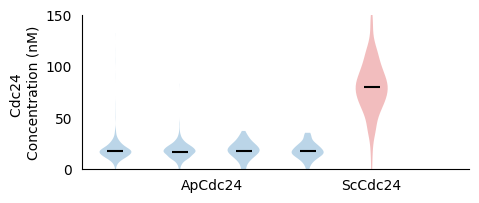

In [36]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap5*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds) 

meds = meds - background

remove_dead_and_background = np.multiply(meds < np.mean(meds)+2*np.std(meds), meds > np.mean(meds)-2*np.std(meds))
meds = meds[remove_dead_and_background]

vols = np.concatenate(vols)
vols = vols[remove_dead_and_background]
yeast_only = np.multiply(50 < vols, vols < 100)
meds = meds * bright_to_conc # conversion factor based on FCS conc meas Ap4 

scmeds = []
scvols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc2*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    scmeds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    scvols.append(v*pix_to_um**3)

scmeds = np.concatenate(scmeds) - background

sc_remove_dead_and_background = np.multiply(scmeds < np.mean(scmeds)+2*np.std(scmeds), scmeds > np.mean(scmeds)-2*np.std(scmeds))
scmeds = scmeds[sc_remove_dead_and_background] * bright_to_conc * 2 # Double becuase is het for probe
scvols = np.concatenate(scvols)[sc_remove_dead_and_background]

fig, ax = plt.subplots(figsize=(5, 2))
set1 = meds[np.multiply(vols > 50, vols <100)]
set2 = meds[np.multiply(vols > 100, vols <200)]
set3 = meds[np.multiply(vols > 200, vols <400)]
set4 = meds[vols > 400]

sets = [set1,set2,set3,set4,scmeds, -100]
parts = ax.violinplot(
        sets, showmeans=True, showmedians=False,
        showextrema=False)
parts["bodies"][-2].set_facecolor("C03")
parts["cmeans"].set_edgecolor("black")
labels = ["ApCdc24", "ScCdc24"]
ax.set_xticks([2.5,5])
ax.set_xticklabels(labels)
ax.tick_params(width=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Cdc24 \nConcentration (nM)")
ax.set_ylim(0,150)
# ax.axis('off') may be useful before export to illustrator
plt.savefig("../figures/conc_Cdc24.png", dpi=1200, bbox_inches='tight')

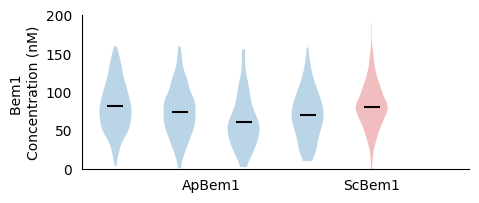

In [37]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap6*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds) 

meds = meds - background

remove_dead_and_background = np.multiply(meds < np.mean(meds)+2*np.std(meds), meds > np.mean(meds)-2*np.std(meds))
meds = meds[remove_dead_and_background]

vols = np.concatenate(vols)
vols = vols[remove_dead_and_background]
yeast_only = np.multiply(50 < vols, vols < 100)
meds = meds * bright_to_conc # conversion factor based on FCS conc meas Ap4 

scmeds = []
scvols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc3*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    scmeds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    scvols.append(v*pix_to_um**3)

scmeds = np.concatenate(scmeds) - background

sc_remove_dead_and_background = np.multiply(scmeds < np.mean(scmeds)+2*np.std(scmeds), scmeds > np.mean(scmeds)-2*np.std(scmeds))
scmeds = scmeds[sc_remove_dead_and_background] * bright_to_conc * 2 # Double becuase is het for probe
scvols = np.concatenate(scvols)[sc_remove_dead_and_background]
fig, ax = plt.subplots(figsize=(5, 2))
set1 = meds[np.multiply(vols > 50, vols <100)]
set2 = meds[np.multiply(vols > 100, vols <200)]
set3 = meds[np.multiply(vols > 200, vols <400)]
set4 = meds[vols > 400]

sets = [set1,set2,set3,set4,scmeds, -100]
parts = ax.violinplot(
        sets, showmeans=True, showmedians=False,
        showextrema=False)
parts["bodies"][-2].set_facecolor("C03")
parts["cmeans"].set_edgecolor("black")
labels = ["ApBem1", "ScBem1"]
ax.set_xticks([2.5,5])
ax.set_xticklabels(labels)
ax.tick_params(width=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Bem1 \nConcentration (nM)")
ax.set_ylim(0,200)
# ax.axis('off') may be useful before export to illustrator
plt.savefig("../figures/conc_Bem1.png", dpi=1200, bbox_inches='tight')

nM per unit intesntiy (red) = 0.0978304222252785


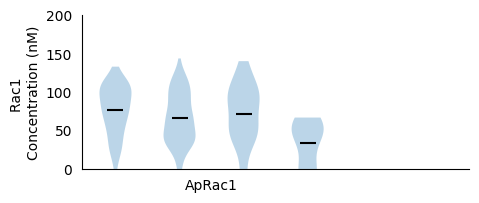

In [11]:
pixelX = 1860 # This is different for images with red probes
micronX = 212.13
pix_to_um = micronX/pixelX
red_background = 110
FCS_conc_rac1 = 76.9

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/ApRac1*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds) 

meds = meds - red_background

remove_dead_and_background = np.multiply(meds < np.mean(meds)+2*np.std(meds), meds > np.mean(meds)-2*np.std(meds))
meds = meds[remove_dead_and_background]

vols = np.concatenate(vols)
vols = vols[remove_dead_and_background]
yeast_only = np.multiply(50 < vols, vols < 100)
print(f"nM per unit intesntiy (red) = {FCS_conc_rac1/np.mean(meds[yeast_only])}") 
meds = meds * 0.098 # conversion factor based on FCS conc meas ApRac1

fig, ax = plt.subplots(figsize=(5, 2))
set1 = meds[np.multiply(vols > 50, vols <100)]
set2 = meds[np.multiply(vols > 100, vols <200)]
set3 = meds[np.multiply(vols > 200, vols <400)]
set4 = meds[vols > 400]

sets = [set1,set2,set3,set4, -100, -100] #-100 is not within range but acts as dummy variable for extended x axis
parts = ax.violinplot(
        sets, showmeans=True, showmedians=False,
        showextrema=False)
parts["cmeans"].set_edgecolor("black")
labels = ["ApRac1"]
ax.set_xticks([2.5])
ax.set_xticklabels(labels)
ax.tick_params(width=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Rac1 \nConcentration (nM)")
ax.set_ylim(0,200)
# ax.axis('off') may be useful before export to illustrator
plt.savefig("../figures/conc_Rac1.png", dpi=1200, bbox_inches='tight')

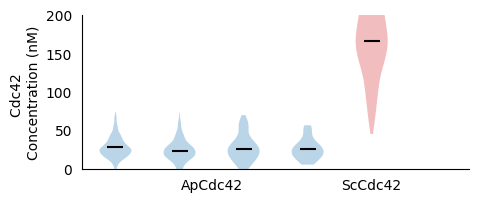

In [20]:
pixelX = 1860 # This is different for images with red probes
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

red_background = 110 # measured in fiji for iamges with red probes

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap12*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds) 

meds = meds - red_background

remove_dead_and_background = np.multiply(meds < np.mean(meds)+2*np.std(meds), meds > np.mean(meds)-2*np.std(meds))
meds = meds[remove_dead_and_background]

vols = np.concatenate(vols)
vols = vols[remove_dead_and_background]
yeast_only = np.multiply(50 < vols, vols < 100)
meds = meds * 0.098 # conversion factor guess for red

scmeds = []
scvols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc8*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    scmeds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    scvols.append(v*pix_to_um**3)

scmeds = np.concatenate(scmeds) - red_background

sc_remove_dead_and_background = np.multiply(scmeds < np.mean(scmeds)+2*np.std(scmeds), scmeds > np.mean(scmeds)-2*np.std(scmeds))
scmeds = scmeds[sc_remove_dead_and_background] * 0.098 * 2 # Is het, need to check if its on its own promoter, as mine are.
# Reportedly 12X overexpressed but then het so 6X. Not doing that now though.
scvols = np.concatenate(scvols)[sc_remove_dead_and_background]

fig, ax = plt.subplots(figsize=(5, 2))
set1 = meds[np.multiply(vols > 50, vols <100)]
set2 = meds[np.multiply(vols > 100, vols <200)]
set3 = meds[np.multiply(vols > 200, vols <400)]
set4 = meds[vols > 400]

sets = [set1,set2,set3,set4,scmeds, -100]
parts = ax.violinplot(
        sets, showmeans=True, showmedians=False,
        showextrema=False)
parts["bodies"][-2].set_facecolor("C03")
parts["cmeans"].set_edgecolor("black")
labels = ["ApCdc42", "ScCdc42"]
ax.set_xticks([2.5,5])
ax.set_xticklabels(labels)
ax.tick_params(width=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Cdc42 \nConcentration (nM)")
ax.set_ylim(0,200)
# ax.axis('off') may be useful before export to illustrator
plt.savefig("../figures/conc_Cdc42.png", dpi=1200, bbox_inches='tight')

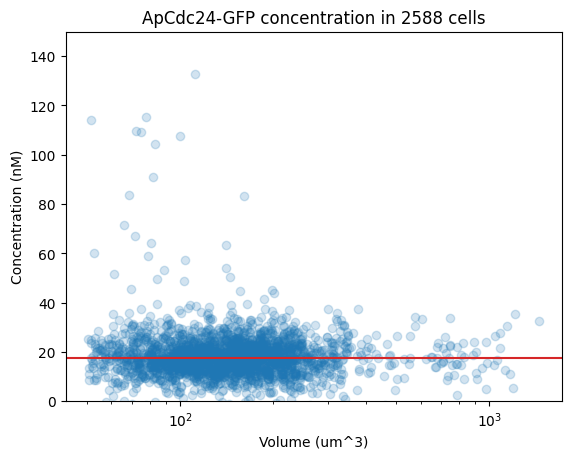

In [40]:
meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap5*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds) 

background = 180
meds = meds - background

remove_dead_and_background = np.multiply(meds < np.mean(meds)+2*np.std(meds), meds > np.mean(meds)-2*np.std(meds))
meds = meds[remove_dead_and_background]

vols = np.concatenate(vols)
vols = vols[remove_dead_and_background]
yeast_only = np.multiply(50 < vols, vols < 100)
meds = meds * bright_to_conc # conversion factor based on FCS conc meas Ap4 


is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.median(meds), color="C03")
plt.ylim(0, 150)
plt.xlabel("Volume (um^3)")
plt.ylabel("Concentration (nM)")
plt.title(f"ApCdc24-GFP concentration in {len(meds)} cells")
plt.xscale("log")

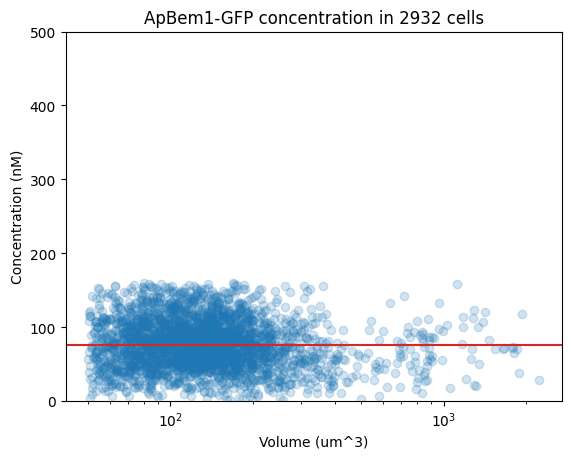

In [42]:
meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap6*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds) 

background = 180
meds = meds - background

remove_dead_and_background = np.multiply(meds < np.mean(meds)+2*np.std(meds), meds > np.mean(meds)-2*np.std(meds))
meds = meds[remove_dead_and_background]

vols = np.concatenate(vols)
vols = vols[remove_dead_and_background]
yeast_only = np.multiply(50 < vols, vols < 100)
meds = meds * bright_to_conc # conversion factor based on FCS conc meas Ap4 


is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.median(meds), color="C03")
plt.ylim(0, 500)
plt.xlabel("Volume (um^3)")
plt.ylabel("Concentration (nM)")
plt.title(f"ApBem1-GFP concentration in {len(meds)} cells")
plt.xscale("log")

Text(0.5, 1.0, 'ScCdc24-GFP concentration in 1266 cells')

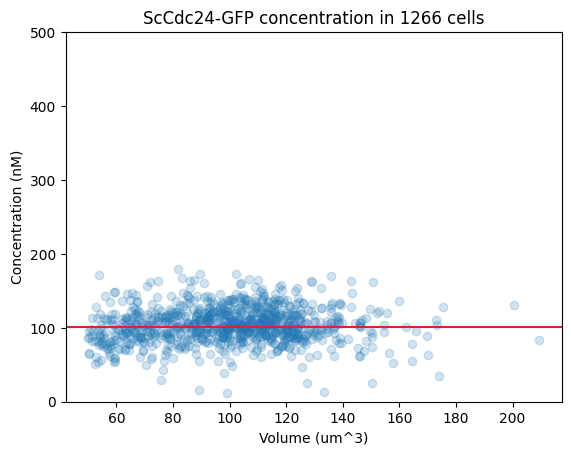

In [43]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc2*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds)*2*bright_to_conc
not_af = meds<5000
meds = meds[not_af]
vols = np.concatenate(vols)[not_af]

is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.median(meds), color="C03")
plt.ylim(0, 500)
plt.xlabel("Volume (um^3)")
plt.ylabel("Concentration (nM)")
plt.title(f"ScCdc24-GFP concentration in {len(meds)} cells")
#plt.xscale("log")

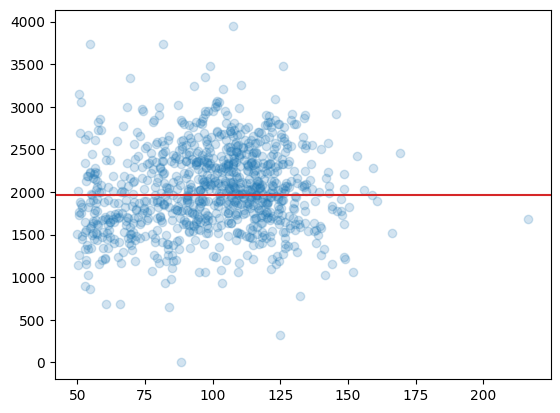

In [342]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc4*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds)*2
not_af = meds<5000
meds = meds[not_af]
vols = np.concatenate(vols)[not_af]

is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.median(meds), color="C03")
#plt.ylim(0, 5000)

In [168]:
dat = np.load('../data/2024_09_10-NiceImgs/Ap4_confocal-1_seg.npy', allow_pickle=True).item()
img = io.imread('../data/2024_09_10-NiceImgs/Ap4_confocal-1.tif')
labels = dat["masks"]
props = regionprops_table(
    labels, img,
    properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
)

In [174]:
np.median(img.ravel())

187.0

(0.0, 4000.0)

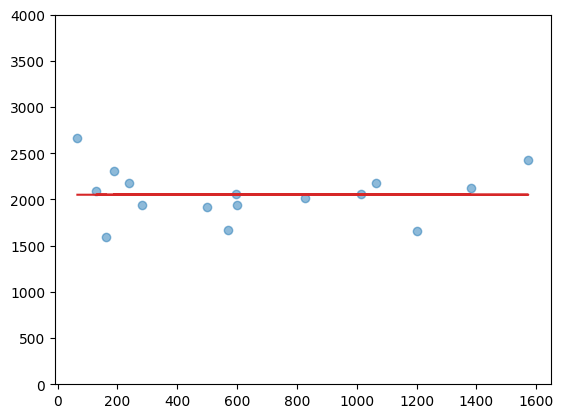

In [87]:
means = props["intensity_mean"]
vols = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
vols = vols*pix_to_um**3
is_cell_sized = vols>50
plt.scatter(vols[is_cell_sized], means[is_cell_sized], alpha=0.5)
b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.plot(vols[is_cell_sized], b + np.multiply(vols[is_cell_sized],m), color="C03")
plt.ylim(0, 4000)

In [97]:
np.concatenate([means,means])

array([2661.3282892 , 2122.5861173 , 1671.09561548, 2307.23174157,
       1935.30564821, 2058.99618063, 2061.71988143, 2014.92975734,
       2425.76958525, 1914.57074207, 1662.12662651, 1945.05522289,
       2183.32937434, 2173.83669429, 2087.66743317, 1598.5687751 ,
       2661.3282892 , 2122.5861173 , 1671.09561548, 2307.23174157,
       1935.30564821, 2058.99618063, 2061.71988143, 2014.92975734,
       2425.76958525, 1914.57074207, 1662.12662651, 1945.05522289,
       2183.32937434, 2173.83669429, 2087.66743317, 1598.5687751 ])

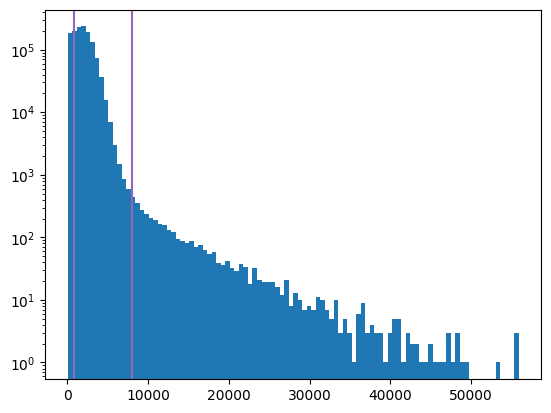

In [25]:
all_masked = img[dat["masks"]>0]
plt.hist(img[dat["masks"]>0], bins=100)
plt.yscale("log")
plt.axvline(800, color="C04")
plt.axvline(8000, color="C04")

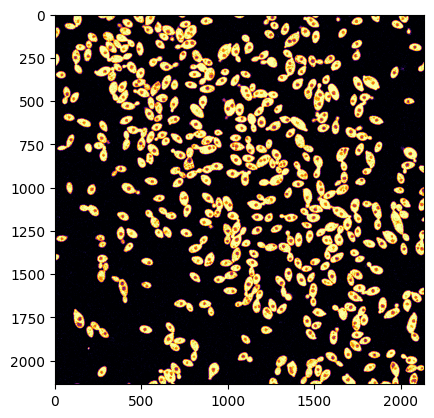

In [31]:
plt.imshow(img>800, cmap="inferno")

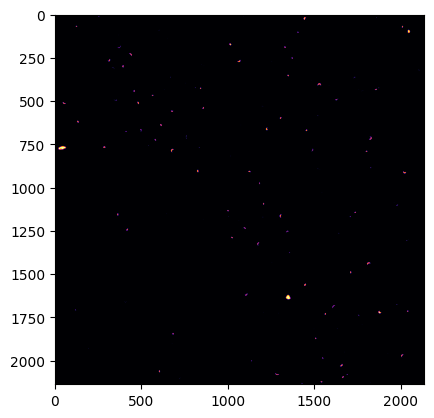

In [32]:
plt.imshow(img>8000, cmap="inferno")

(0.0, 4000.0)

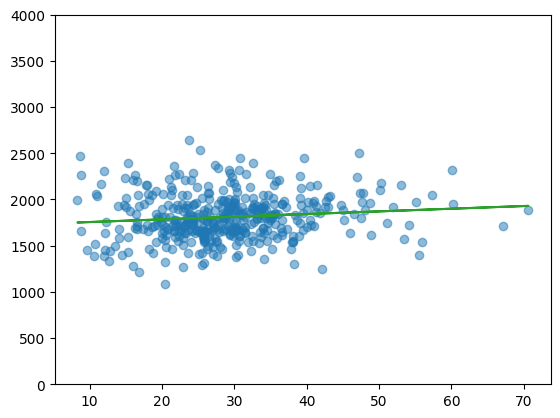

In [40]:
meds = []
pixels = []
for n in np.unique(clear_border(dat["masks"])):
    if n == 0:
        pass
    else:
        mask = dat["masks"] == n
        cell = img[mask]
        px = len(cell.ravel())
        if px > 800:
            pixels.append(px)
            meds.append(np.median(cell))
#plt.hist(meds, bins=100)
#plt.hist(pixels, bins=100)

sq_microns = np.multiply(pixels,pix_area)
plt.scatter(sq_microns, meds, alpha=0.5)
b, m = polyfit(sq_microns, meds, 1)
plt.plot(sq_microns, b + np.multiply(sq_microns,m), color="C02")
plt.ylim(0, 4000)

(0.0, 4000.0)

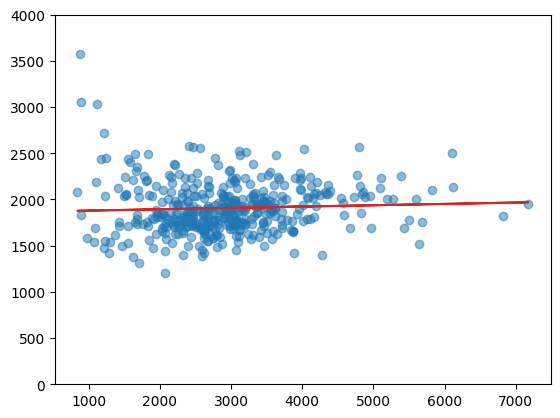

In [95]:
means = []
pixels = []
for n in np.unique(clear_border(dat["masks"])):
    if n == 0:
        pass
    else:
        mask = dat["masks"] == n
        cell = img[mask]
        px = len(cell.ravel())
        if px > 800:
            pixels.append(px)
            means.append(np.mean(cell))
#plt.hist(meds, bins=100)
#plt.hist(pixels, bins=100)
plt.scatter(pixels, means, alpha=0.5)

b, m = polyfit(pixels, means, 1)
plt.plot(pixels, b + np.multiply(pixels,m), color="C03")
plt.ylim(0, 4000)

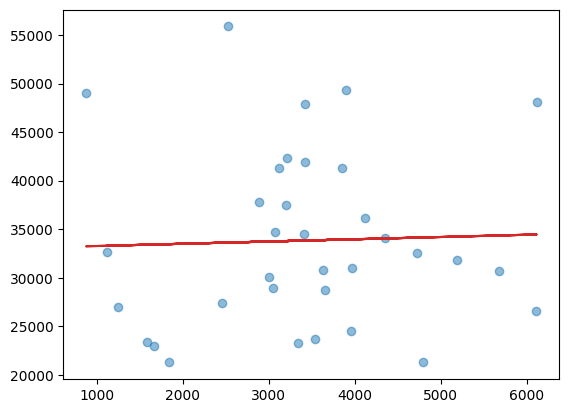

In [106]:
maxes = []
pixels = []
for n in np.unique(clear_border(dat["masks"])):
    if n == 0:
        pass
    else:
        mask = dat["masks"] == n
        cell = img[mask]
        px = len(cell.ravel())
        if px > 800 and np.max(cell) > 20000:
            pixels.append(px)
            maxes.append(np.max(cell))
#plt.hist(meds, bins=100)
#plt.hist(pixels, bins=100)
plt.scatter(pixels, maxes, alpha=0.5)

b, m = polyfit(pixels, maxes, 1)
plt.plot(pixels, b + np.multiply(pixels,m), color="C03")
